# LightGBM

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from preprocess import Preprocess
import seaborn as sns

pd.set_option("display.max_columns", None)

Importing data and defining column names

In [4]:
data_path = "../../data/"
label_col = "Label"

train_df = pd.read_csv(data_path + "train.csv")
drop_cols = [
    # "time",
    "SNo"
]

train_df = train_df.drop(drop_cols, axis=1)
train_df = train_df.sort_values(by="Label")
# train_data = train_df.drop_duplicates(keep="last")
train_data = train_df.sample(frac=0.7)
validation_data = train_df.iloc[~train_data.index]

X = train_data.drop(["Label"], axis=1).copy()
y = train_data[label_col].copy()

X_valid = validation_data.drop(["Label"], axis=1).copy()
y_valid = validation_data[label_col].copy()

Squaring cols + magnitude of the wind

In [6]:
data_path = "../../data/"
label_col = "Label"

train_df = pd.read_csv(data_path + "train.csv")

preproc = Preprocess()

train_df = train_df.drop(drop_cols, axis=1)
train_df = train_df.sort_values(by="Label")

train_df = train_df[['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500', "Label"]]
train_data = train_df.drop_duplicates(keep="last")

train_data = train_df.sample(frac=0.7)
validation_data = train_df.iloc[~train_data.index]

X = train_data.drop(["Label"], axis=1).copy()
y = train_data[label_col].copy()

X_valid = validation_data.drop(["Label"], axis=1).copy()
y_valid = validation_data[label_col].copy()

In [7]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_valid, label=y_valid)

In [8]:
X_scaled.columns

Index(['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT',
       'T500'],
      dtype='object')

Train lightgbm

In [9]:
# Define parameters (adjust these as per your needs)
parameters = {
    # "objective": "multiclass",
    # "num_class": 3,
    # 'eval_metric': ["accuracy", "softmax"],
    # "class_weight": {0: 1, 1: 3, 2:1.3},
    'is_unbalance': 'true',
#     'boosting': 'gbdt',
    "max_bin": 3,
    "max_depth": 4,
    "num_leaves": 16,
    # "num_iterations": 200,
#     "n_jobs": 1,
#     "lambda_l1": 0.2,  # L1 regularization term. Adjust as needed.
#     "lambda_l2": 0.2,  # L2 regularization term. Adjust as needed.
#     # "verbose_eval": -1,
#     # "early_stopping_round": 4,
}

# # Train model
model_lgbm = lgb.LGBMClassifier(**parameters, boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective="multiclass", num_class=3,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-100)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
scores = cross_validate(model_lgbm, X=X_scaled, y=y,cv=5,scoring="accuracy")
model_lgbm.fit(X=X_scaled, y=y)

LGBMClassifier(is_unbalance='true', n_jobs=-1, num_class=3,
               objective='multiclass', random_state=123, verbose=-100)

In [10]:
print("scores:", scores["test_score"])
print("mean:", scores["test_score"].mean())
print("diff :", scores["test_score"].max() - scores["test_score"].min())

scores: [0.88862295 0.88431466 0.8881264  0.88333865 0.88573252]
mean: 0.8860270367823269
diff : 0.005284292539804003


In [11]:
y_valid.value_counts()


0    24674
2     5391
1     1267
Name: Label, dtype: int64

In [12]:
confusion_matrix(y_valid, model_lgbm.predict(X=X_valid),)

array([[23721,   152,   801],
       [  379,   880,     8],
       [ 1607,    46,  3738]])

In [13]:
accuracy_score(model_lgbm.predict(X=X_valid), y_valid)

0.9044746584961062

In [14]:
y_valid.value_counts(normalize=True)

0    0.787502
2    0.172061
1    0.040438
Name: Label, dtype: float64

In [15]:
pd.Series(model_lgbm.predict(X=X_valid)).value_counts(normalize=True)

0    0.820471
2    0.145123
1    0.034406
dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

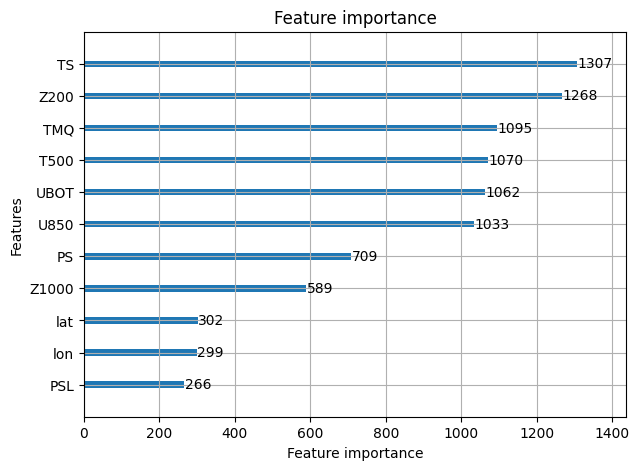

In [16]:
lgb.plot_importance(model_lgbm, height=0.2, figsize=(7,5))

In [17]:
test_data = pd.read_csv(data_path + "test.csv")

preproc = Preprocess()

test_data = test_data[["SNo", 'lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500']]

scaler = StandardScaler()
test_data_sel = scaler.fit_transform(test_data.drop("SNo", axis=1))

In [18]:
pd.DataFrame(model_lgbm.predict(test_data_sel))[0].value_counts(normalize=True)

0    0.854942
2    0.110659
1    0.034399
Name: 0, dtype: float64

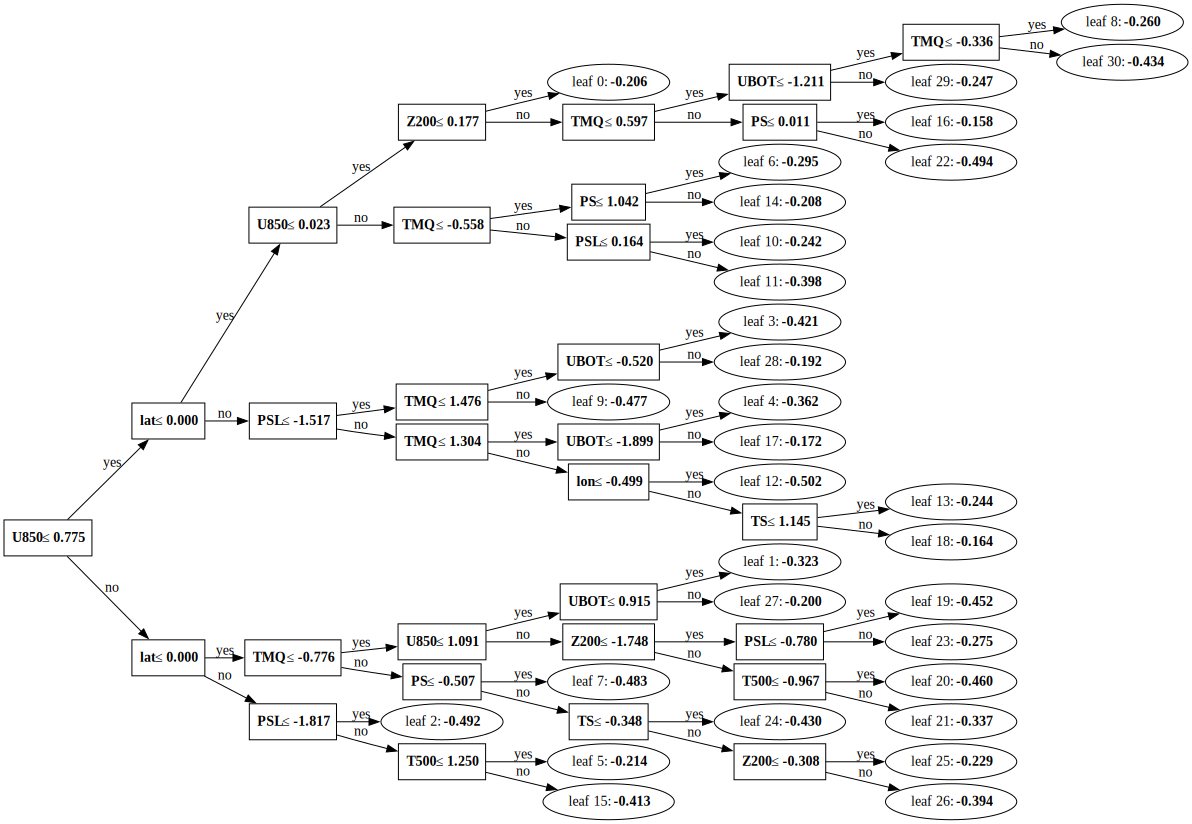

In [20]:
lgb.create_tree_digraph(model_lgbm)

In [200]:
test_data['Label'] = model_lgbm.predict(test_data_sel)

In [201]:
submission = test_data[["SNo", "Label"]].copy()

In [202]:
submission

,SNo,Label
0,1,0
1,2,0
2,3,2
3,4,2
4,5,0
...,...,...
10315,10316,0
10316,10317,0
10317,10318,0
10318,10319,0


In [203]:
# submition.drop("index", axis=1, inplace=True)
submission.to_csv(f"predictions_lightgbm_{datetime.now()}_same_log_reg_cols.csv", index=False)